# Regularized least squared problem with kernels with position and velocity as input

### import libraries

In [492]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn
from scipy.optimize import minimize
from scipy.linalg import solve

### General system for damped oscilator

$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (eigenfrequency)
- $ t $: Time unit.

In [493]:
zeta = 0*0.2/np.sqrt(2)
omega_0 = 0.2* 2* np.pi
def damped_oscillator(t, x):  #remember that independent value t comes first
    x_dot = - 2* zeta * omega_0 * x[1] - omega_0**2 * x[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [x[1], x_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.
m = 1
k = m * omega_0**2
c = 2* zeta * np.sqrt(k * m) 

### solving the differential equation numerically with scipy

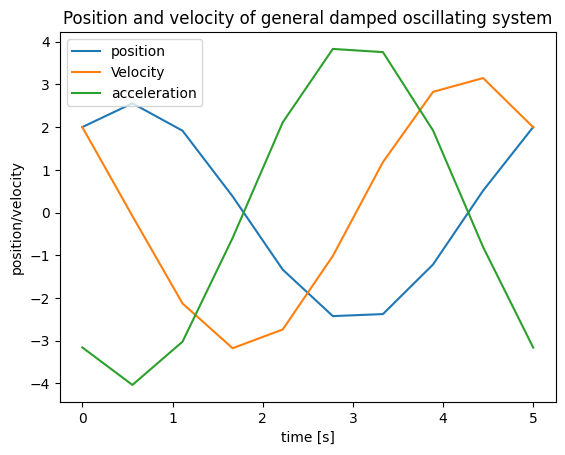

In [494]:
init_values = [2, 2]  # Initial condition [position, velocity]
num_datapoints = 10
timespan = [0, 5]
t = np.linspace(0, 5, num_datapoints)
sol = solve_ivp(damped_oscillator, (t[0], t[-1]), init_values, t_eval = t)#time interval first, then initial values for position and velocity
q  = sol.y[0]
dq = sol.y[1]
ddq = - 2* zeta * omega_0 * dq - omega_0**2 * q  #calculating accelerations from positions and velocities

plt.plot(t, q, label = "position")
plt.plot(t, dq, label = "Velocity")
plt.plot(t, ddq, label = "acceleration")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

### Phase plot of the oscilator

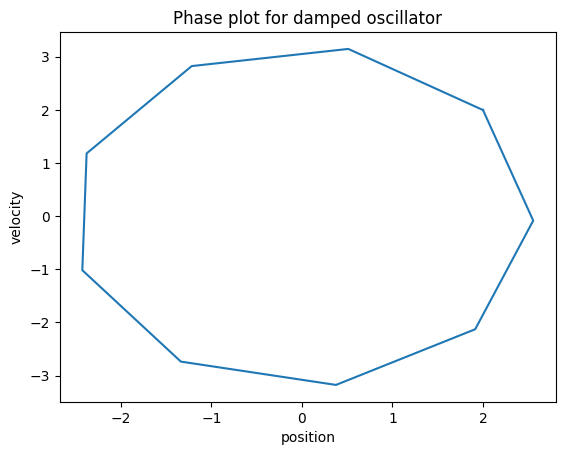

In [495]:
plt.plot(q, dq)
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Phase plot for damped oscillator")
plt.show()

### Discretizing the dataset for with gaussian noise

In [496]:
noise_std = 0.1
def generate_noisy_data(q, dq, ddq, noise_std):
    gaussian_noise = np.random.normal(0, noise_std, len(q))
    # Add noise to position, velocity, and acceleration
    q_noisy = q + gaussian_noise
    dq_noisy = dq + gaussian_noise
    ddq_noisy = ddq + gaussian_noise
    
    # Update input and target outputs
    input_data = np.column_stack((q_noisy, dq_noisy))
    target_outputs = np.column_stack((dq_noisy, ddq_noisy))
    
    return input_data, target_outputs
    
input_data, target_outputs = generate_noisy_data(q, dq, ddq, noise_std)
num_states = input_data.shape[1]

#### Tuning of $𝜆$ and $𝜎$
 - Lambda ($𝜆$): This is the regularization parameter that controls the trade-off between minimizing error on the training data and keeping the model complexity low. Higher $𝜆$ values apply stronger regularization, leading to simpler, smoother solutions that generalize better.

 - Sigma ($𝜎$): In the RBF kernel, $𝜎$, controls the spread of the kernel, defining how quickly similarity decays with distance. Smaller 
$𝜎$ results in a highly localized influence (risking overfitting), whereas larger $𝜎$ smooths the influence over a broader area (which may underfit).

### Computing the gassian kernel matrix

In [497]:
sigma, lam = [10, 0.0001]
def rbf_kernel(x, y, sigma):
    x, y = np.asarray(x), np.asarray(y)  # Konverter til numpy-arrays
    k = np.exp(-(np.linalg.norm(x - y)**2) / (2 * sigma**2))
    return k

def first_partial_derivative(x, u, sigma):
    """Compute the first partial derivative of the RBF kernel with respect to x."""
    kernel_value = rbf_kernel(x, u, sigma)
    return -np.sum((x - u) / sigma**2) * kernel_value

def second_partial_derivative(x, u, sigma):
    """Compute the second partial derivative of the RBF kernel with respect to x."""
    kernel_value = rbf_kernel(x, u, sigma)
    dist_sq = np.sum((x - u)**2)
    return kernel_value * ((dist_sq - sigma**2) / sigma**4)

def lagrangian_kernel(x, u, sigma):
    """Compute the Lagrangian kernel for a damped oscillator."""
    kernel_value = rbf_kernel(x, u, sigma)
    
    # Kinetic term: mass * second partial derivative
    kinetic_term = m * second_partial_derivative(x, u, sigma)
    
    # Potential term: spring constant * kernel value
    potential_term = k * kernel_value
    
    # Damping term: damping coefficient * first partial derivative
    damping_term = c * first_partial_derivative(x, u, sigma)
    
    return kinetic_term + potential_term + damping_term

def gram(x_list, sigma):
    n = x_list.shape[0]
    k_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            k_mat[i, j] = rbf_kernel(x_list[i], x_list[j], sigma)
    return k_mat   

def gram2(x_list, sigma):
    n = x_list.shape[0]
    k_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            k_mat[i, j] = first_partial_derivative(x_list[i], x_list[j], sigma)
    return k_mat   
K = gram(input_data, sigma)
K2 = gram2(input_data, sigma)

### Solve the minimization problem to obtain dual coefficients $a$

In [498]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]
    K_reg = K + lambd * np.eye(n)
    alpha = np.linalg.solve(K_reg, y)
    return alpha
alpha = dual_coeff(K, target_outputs, lam)  #2D column vector

target_velocity = target_outputs[:, 0]  # Velocity targets
target_acceleration = target_outputs[:, 1]  # Acceleration targets

# Solve for dual coefficients
alpha_velocity = dual_coeff(K, target_velocity, lam)
alpha_acceleration = dual_coeff(K2, target_acceleration, lam)

### Estimate the function based on $a$ and kernel matrix

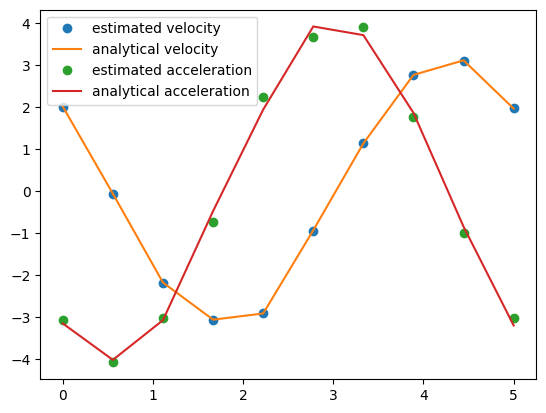

In [499]:
def learned_outputs(x, alpha_velocity, alpha_acceleration, input_data, sigma):
    """
    Compute velocity and acceleration using the Lagrangian kernel for both outputs.
    """
    num_points = len(x)
    velocity = np.zeros(num_points)
    acceleration = np.zeros(num_points)
    
    for i in range(num_points):
        for j in range(len(input_data)):
            # Compute kernel value for velocity
            kernel_value = rbf_kernel(x[i], input_data[j], sigma)
            velocity[i] += alpha_velocity[j] * kernel_value
            
            # Compute kernel derivative for acceleration
            kernel_derivative = first_partial_derivative(x[i], input_data[j], sigma)
            acceleration[i] += alpha_acceleration[j] * kernel_derivative
    
    return np.column_stack((velocity, acceleration))

f = learned_outputs(input_data, alpha_velocity, alpha_acceleration,input_data, sigma)

plt.plot(t, f[:,0],'o', label = "estimated velocity")
plt.plot(t, input_data[:,1], label = "analytical velocity")
plt.plot(t, f[:,1],'o', label = "estimated acceleration")
plt.plot(t, target_outputs[:,1], label = "analytical acceleration")
plt.legend()
plt.show()

### Solve learned outputs to get trajectories

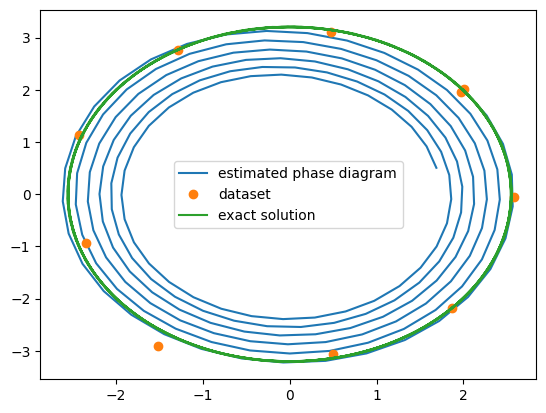

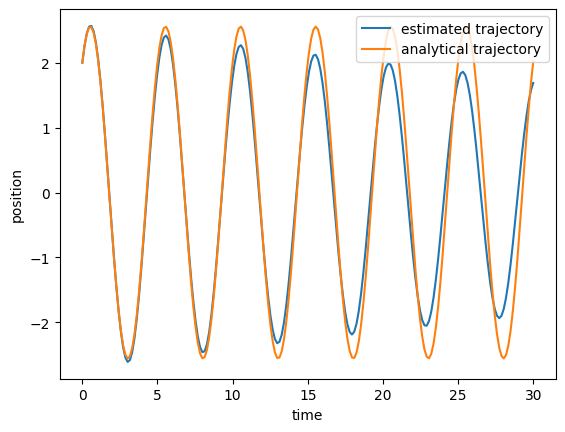

In [500]:
def ivp_learned_outputs(t, x):
    velocity = 0.0
    acceleration = 0.0
    
    for j in range(len(input_data)):
        # Compute kernel value for velocity
        kernel_value = rbf_kernel(x, input_data[j], sigma)
        velocity += alpha_velocity[j] * kernel_value
        
        # Compute kernel derivative for acceleration
        kernel_derivative = first_partial_derivative(x, input_data[j], sigma)
        acceleration += alpha_acceleration[j] * kernel_derivative
    
    return np.array([velocity, acceleration])  # Return [velocity, acceleration]
   

sol = solve_ivp(ivp_learned_outputs, (0, 30), init_values, t_eval=np.linspace(0, 30, 200))
sol_exact = solve_ivp(damped_oscillator, (0, 30), init_values, t_eval = np.linspace(0, 30, 200))

plt.plot(sol.y[0], sol.y[1], label = "estimated phase diagram")
plt.plot(input_data[:,0], input_data[:,1], 'o', label = "dataset")
plt.plot(sol_exact.y[0], sol_exact.y[1], label = "exact solution")
plt.legend()
plt.savefig("damped_osciallator")
plt.show()
plt.plot(np.linspace(0, 30, 200), sol.y[0], label= "estimated trajectory")
plt.plot(np.linspace(0, 30, 200), sol_exact.y[0], label = "analytical trajectory")
plt.xlabel("time")
plt.ylabel("position")
plt.legend()
plt.show()

### Solving the learned outputs to get learned trajectories 

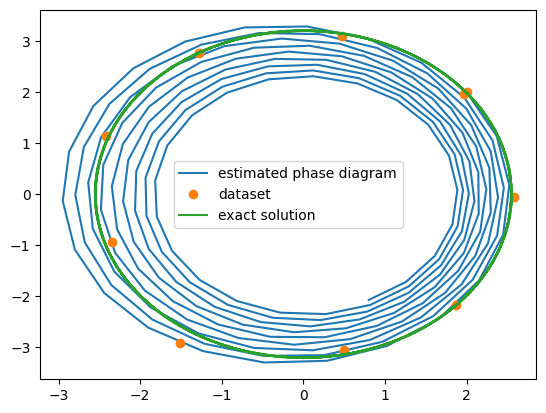

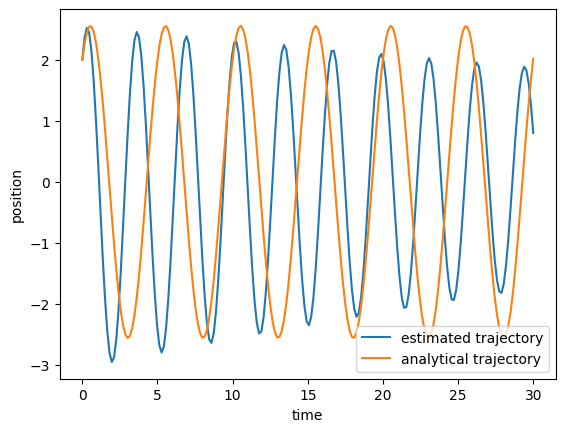

In [501]:
def ivp_learned_outputs(t, x):
    f = np.zeros(2)  # Output array for [velocity, acceleration]
    # Loop over all training points to compute the weighted sum of kernel values
    for j in range(num_datapoints):
        kernel_value = lagrangian_kernel(x, input_data[j], sigma)  # Compute kernel value
        f += alpha[j] * kernel_value  # Weighted sum using learned coefficients
    return f  # Return [velocity, acceleration]

sol = solve_ivp(ivp_learned_outputs, (0, 30), init_values, t_eval=np.linspace(0, 30, 200))
sol_exact = solve_ivp(damped_oscillator, (0, 30), init_values, t_eval = np.linspace(0, 30, 200))

plt.plot(sol.y[0], sol.y[1], label = "estimated phase diagram")
plt.plot(input_data[:,0], input_data[:,1], 'o', label = "dataset")
plt.plot(sol_exact.y[0], sol_exact.y[1], label = "exact solution")
plt.legend()
plt.savefig("damped_osciallator")
plt.show()
plt.plot(np.linspace(0, 30, 200), sol.y[0], label= "estimated trajectory")
plt.plot(np.linspace(0, 30, 200), sol_exact.y[0], label = "analytical trajectory")
plt.xlabel("time")
plt.ylabel("position")
plt.legend()
plt.show()

In [502]:
def evaluate_mse(true_q, pred_q, true_qdot, pred_qdot, weight_q=0.5, weight_qdot=0.5):
    # Compute individual MSE
    mse_q = np.mean((true_q - pred_q)**2)
    mse_qdot = np.mean((true_qdot - pred_qdot)**2)
    # Combine with weights
    total_mse = weight_q * mse_q + weight_qdot * mse_qdot
    return mse_q, mse_qdot, total_mse

def average_mse(num_runs, p, v, a, noise_std, sigma, lam, damped_oscillator, init_values, t_eval):
    mse_q_list, mse_qdot_list, total_mse_list = [], [], []
    for _ in range(num_runs):
        # Generate noisy data
        input_data, target_outputs = generate_noisy_data(p, v, a, noise_std)
        
        # Compute Gram matrix and dual coefficients
        K = gram(input_data, sigma)
        K2 = gram2(input_data, sigma)
        alpha_velocity = dual_coeff(K, target_velocity, lam)
        alpha_acceleration = dual_coeff(K2, target_acceleration, lam)
        # Solve learned dynamics
        def ivp_learned_outputs(t, x):
            velocity = 0.0
            acceleration = 0.0
            
            for j in range(len(input_data)):
                # Compute kernel value for velocity
                kernel_value = rbf_kernel(x, input_data[j], sigma)
                velocity += alpha_velocity[j] * kernel_value
                
                # Compute kernel derivative for acceleration
                kernel_derivative = first_partial_derivative(x, input_data[j], sigma)
                acceleration += alpha_acceleration[j] * kernel_derivative
    
            return np.array([velocity, acceleration])  # Return [velocity, acceleration]
        
        sol = solve_ivp(ivp_learned_outputs, [0, 30], init_values, t_eval=t_eval)
        sol_exact = solve_ivp(damped_oscillator, [0, 30], init_values, t_eval=t_eval)
        
        # Compute MSE
        mse_q, mse_qdot, total_mse = evaluate_mse(
            sol_exact.y[0], sol.y[0],
            sol_exact.y[1], sol.y[1]
        )
        
        # Store results
        mse_q_list.append(mse_q)
        mse_qdot_list.append(mse_qdot)
        total_mse_list.append(total_mse)

    # Compute averages and standard deviations
    avg_mse_q = np.mean(mse_q_list)
    std_mse_q = np.std(mse_q_list)

    avg_mse_qdot = np.mean(mse_qdot_list)
    std_mse_qdot = np.std(mse_qdot_list)

    avg_total_mse = np.mean(total_mse_list)
    std_total_mse = np.std(total_mse_list)

    return avg_mse_q, std_mse_q, avg_mse_qdot, std_mse_qdot, avg_total_mse, std_total_mse

num_runs = 50
t_eval = np.linspace(0, 30, 200)
results = average_mse(
    num_runs=num_runs,
    p=q,
    v=dq,
    a=ddq,
    noise_std=noise_std,
    sigma=sigma,
    lam=lam,
    damped_oscillator=damped_oscillator,
    init_values=init_values,
    t_eval=t_eval
)


print(f"Average MSE (Position): {results[0]:.4f} ± {results[1]:.4f}")
print(f"Average MSE (Velocity): {results[2]:.4f} ± {results[3]:.4f}")
print(f"Average Total MSE: {results[4]:.4f} ± {results[5]:.4f}")


Average MSE (Position): 1.0814 ± 2.1040
Average MSE (Velocity): 1.8026 ± 3.7257
Average Total MSE: 1.4420 ± 2.9128
